In [ ]:
 ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
 ! cp /content/drive/MyDrive/Colab_Notebooks/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download sylviahamidah/cattle-tongue-dataset

 98% 94.0M/96.0M [00:07<00:00, 21.5MB/s]
100% 96.0M/96.0M [00:07<00:00, 13.0MB/s]


In [ ]:
! unzip /content/cattle-tongue-dataset.zip


Archive:  /content/cattle-tongue-dataset.zip
  inflating: tongue_dataset/fmd/augmented_fmdf_0.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_1.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_10.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_100.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_101.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_102.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_103.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_104.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_105.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_106.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_107.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_108.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_109.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_11.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_110.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_111.jpg  
  inflating: tongue_dataset/fmd/augmented_fmdf_11

In [ ]:
#Import the libraries
import zipfile
import os
import shutil
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np

#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/NETKIT BISA/datasets/dataset_feet.zip', 'r') #Opens the zip file in read mode
#zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
#zip_ref.close()

In [ ]:
# directories
dir_list = ['/tongue_dataset/fmd', '/tongue_dataset/healthy']

base_dir = '/tmp/dataset'
train_dir = '/tmp/dataset/train/'
test_dir = '/tmp/dataset/test/'

train_aug = '/tmp/augmented/train/'
test_aug = '/tmp/augmented/test/'

classes = ['fmd_tongue', 'healthy_tongue']

In [ ]:
# Create new folders
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

for i in classes:
  os.mkdir(os.path.join(train_dir,i))
for k in classes:
  os.mkdir(os.path.join(test_dir,k))


In [ ]:
# FUNCTION: split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  # Shuffle list
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = TESTING



In [ ]:
# Test your split_data function

# Define paths
FMDF_SOURCE_DIR = "/content/tongue_dataset/fmd"
HEALTHYF_SOURCE_DIR = "/content/tongue_dataset/healthy"

TRAINING_DIR = "/tmp/dataset/train"
TESTING_DIR = "/tmp/dataset/test"

TRAINING_FMDF_DIR = "/tmp/dataset/train/fmd_tongue"
TESTING_FMDF_DIR = "/tmp/dataset/test/fmd_tongue"

TRAINING_HEALTHYF_DIR = "/tmp/dataset/train/healthy_tongue"
TESTING_HEALTHYF_DIR = "/tmp/dataset/test/healthy_tongue"


# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_HEALTHYF_DIR)) > 0:
  for file in os.scandir(TRAINING_HEALTHYF_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_FMDF_DIR)) > 0:
  for file in os.scandir(TRAINING_FMDF_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_HEALTHYF_DIR)) > 0:
  for file in os.scandir(TESTING_HEALTHYF_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_FMDF_DIR)) > 0:
  for file in os.scandir(TESTING_FMDF_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(FMDF_SOURCE_DIR, TRAINING_FMDF_DIR, TESTING_FMDF_DIR, split_size)
split_data(HEALTHYF_SOURCE_DIR, TRAINING_HEALTHYF_DIR, TESTING_HEALTHYF_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_HEALTHYF_DIR))} images of healthy feet for training")
print(f"There are {len(os.listdir(TRAINING_FMDF_DIR))} images of fmd feet for training")
print(f"There are {len(os.listdir(TESTING_HEALTHYF_DIR))} images of healthy feet for testing")
print(f"There are {len(os.listdir(TESTING_FMDF_DIR))} images of fmd feet for testing")



There are 168 images of healthy feet for training
There are 173 images of fmd feet for training
There are 42 images of healthy feet for testing
There are 44 images of fmd feet for testing


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 60,
                                     width_shift_range = 0.4,
                                     height_shift_range = 0.4,
                                     shear_range = 0.4,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 20,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 10,
                                                                class_mode = 'binary',
                                                                target_size = (150, 150))
  ### END CODE HERE
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)


Found 341 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


In [ ]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

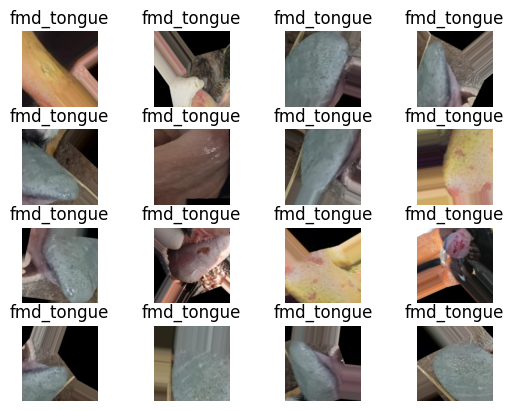

In [ ]:
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
  plt.imshow(images[i])
  plt.title(f'{labels[np.argmax(titles[i],axis=0)]}')
  plt.axis("off")

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
inc_history = model.fit_generator(train_generator,
                                  validation_data = validation_generator,
                                  epochs = 50)

<ipython-input-23-c1db79026b55>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  inc_history = model.fit_generator(train_generator,


Epoch 1/50
18/18 [==============================] - 25s 686ms/step - loss: 3.8071 - acc: 0.6481 - val_loss: 0.2211 - val_acc: 0.8837
Epoch 2/50
18/18 [==============================] - 10s 549ms/step - loss: 0.6180 - acc: 0.8211 - val_loss: 0.1380 - val_acc: 0.9302
Epoch 3/50
18/18 [==============================] - 10s 495ms/step - loss: 0.7919 - acc: 0.7801 - val_loss: 0.1261 - val_acc: 0.9419
Epoch 4/50
18/18 [==============================] - 9s 524ms/step - loss: 0.3982 - acc: 0.8592 - val_loss: 0.1527 - val_acc: 0.9419
Epoch 5/50
18/18 [==============================] - 10s 535ms/step - loss: 0.2322 - acc: 0.9091 - val_loss: 0.1087 - val_acc: 0.9535
Epoch 6/50
18/18 [==============================] - 9s 512ms/step - loss: 0.3261 - acc: 0.8827 - val_loss: 0.1876 - val_acc: 0.9419
Epoch 7/50
18/18 [==============================] - 10s 519ms/step - loss: 0.4033 - acc: 0.8915 - val_loss: 0.0751 - val_acc: 0.9535
Epoch 8/50
18/18 [==============================] - 9s 495ms/step - los

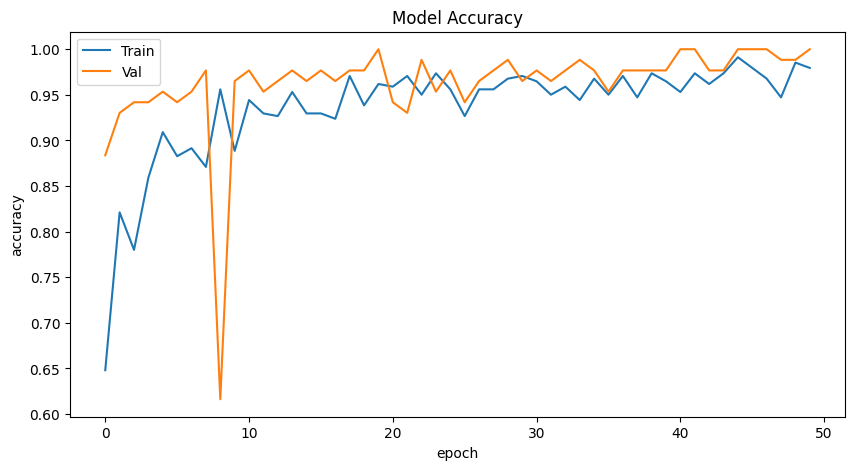

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(inc_history.history['acc'])
plt.plot(inc_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

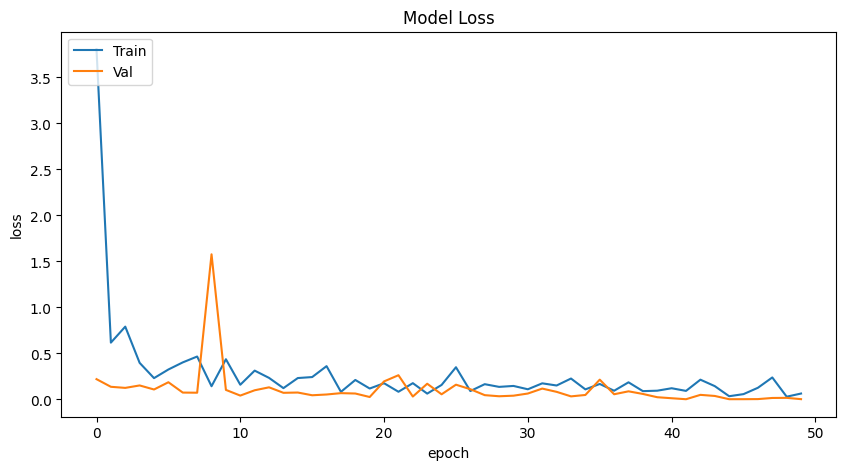

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0][0])
  percent = "{:.2f}".format(100 - classes[0][0]*100)
  print("Healthy percentage: %.2f%%" % (classes[0][0]*100))


Saving lidah crop.png to lidah crop.png
1/1 [==============================] - 0s 33ms/step
2.9957548e-08
Healthy percentage: 0.00%


In [ ]:
if classes[0]>0.5:
  print("Sapi Anda tidak mengalami gejala PMK berdasarkan pemindaian pada lidah.")
else:
  print("Sapi Anda memiliki kemungkinan mengalami PMK berdasarkan gejala pada lidah sebesar " + percent + "%.")

Sapi Anda memiliki kemungkinan mengalami PMK berdasarkan gejala pada lidah sebesar 100.00%.


In [ ]:
model.save("inc_model_tongue.h5")